# Title: Attack Graph Metrics
### Purpose: Snippets to review published AG Metrics
### Author: @mjz


## Overview / BLUF


Boromir is our attack graph framework integrated into PKB to provide end to end security benchmarking. 

The example run of Boromir shown here to demonstrate:

In [22]:

%%bash
/opt/projects/diss/py-mulval/src/run_boromir.py --benchmarks=shortest_attack_path --benchmark_config_file=test_flags_in_config.yml --secmet_plot_intermediate_graphs --secmet_fix_cvss_score=1 


-------------------------BOROMIR Results Summary-------------------------
SHORTEST_ATTACK_PATH:
  attack_graph_name="single_host_1" citation="Marc Dacier, Yves Deswarte, and Mohamed Kaâniche. 1996. Quantitative assessment of operational security: Models and tools. Information Systems Security, ed. by SK Katsikas and D. Gritzalis, London, Chapman & Hall (1996), 179–86." cite_key="dacier1996" metric_name="shortest_path" metric_summary="" metric_unit="weeks" run_number="0" shortest_path_length_after="4" shortest_path_length_before="11" transition_matrix="[[0.3333333333333333, 0.3076923076923077, 0.358974358974359, 0.0, 0.0], [0.0, 0.42857142857142855, 0.5714285714285714, 0.0, 0.0], [0.0, 0.0, 0.625, 0.375, 0.0], [0.0, 0.0, 0.0, 0.6923076923076923, 0.3076923076923077], [0.0, 0.0, 0.0, 0.0, 1.0]]" usage=""
  shortest_path                         4.000000 weeks                         
  End to End Runtime                    1.020152 seconds                       

-------------------------

2020-02-12 03:57:02,310 dea68c8c MainThread INFO     Verbose logging to: /tmp/mulpy/runs/dea68c8c/pkb.log
2020-02-12 03:57:02,310 dea68c8c MainThread INFO     PerfKitBenchmarker version: unknown
2020-02-12 03:57:02,310 dea68c8c MainThread INFO     Flag values:
--benchmark_config_file=test_flags_in_config.yml
--secmet_plot_intermediate_graphs
--secmet_fix_cvss_score=1.0
--benchmarks=shortest_attack_path
2020-02-12 03:57:02,325 dea68c8c MainThread INFO     Running: ssh-keygen -t rsa -N  -m PEM -q -f /tmp/mulpy/runs/dea68c8c/py_mulval_keyfile
2020-02-12 03:57:02,341 dea68c8c MainThread INFO     Setting --max_concurrent_threads=200.
2020-02-12 03:57:02,393 dea68c8c MainThread WARNING  The key "secmet_plot_intermediate_graphs" was not in the default config, but was in user overrides. This may indicate a typo.
2020-02-12 03:57:02,394 dea68c8c MainThread shortest_attack_path(1/1) INFO     Provisioning resources for benchmark shortest_attack_path
2020-02-12 03:57:02,394 dea68c8c MainThread sho

The remainder of this notebook shows how the SECMET library can be used to model and evaluate different security metrics

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
import networkx as nx
import graphviz

import IPython.display

import numpy as np
from itertools import chain

import numpy as np
import scipy.stats as st
import scipy.special

import bokeh.io
import bokeh.plotting
import bokeh.application
import bokeh.application.handlers
bokeh.io.output_notebook()

py_mulval_path = r'/opt/projects/diss/py-mulval/src'
sys.path.append(py_mulval_path)

notebook_url = 'localhost:8888'

import py_mulval.attack_graph as attack_graph
from py_mulval.attack_graph import AttackGraph

Loading BokehJS ...

In [80]:
#nocode

# Show an attack graph in this notebook
def plot_ag(ag):
    A = nx.nx_agraph.to_agraph(ag)
    # A.layout('dot', args='-Nfontsize=10 -Nwidth=".2" -Nheight=".2" -Nmargin=0 -Gfontsize=8')
    args = """
    -Gsize=17
    -Nfontname=Roboto
    -Efontname=Roboto
    -Nfontsize=14
    -Efontsize=14
    """
    A.layout('dot', args=args )
    # A.draw(self.outputDir + '/' + outfilename)
    A.draw()
    # plt.show()
    return graphviz.Source(A.to_string())

# from http://bois.caltech.edu/dist_stories/
def distribution_plot_app(x_min=None, x_max=None, scipy_dist=None,
    transform=None, custom_pdf=None, custom_pmf=None, custom_cdf=None, 
    params=None, n=400, plot_height=200, plot_width=300, x_axis_label='x', 
    title=None):
    """
    Build interactive Bokeh app displaying a univariate
    probability distribution.

    Parameters
    ----------
    x_min : float
        Minimum value that the random variable can take in plots.
    x_max : float
        Maximum value that the random variable can take in plots.
    scipy_dist : scipy.stats distribution
        Distribution to use in plotting.
    transform : function or None (default)
        A function of call signature `transform(*params)` that takes
        a tuple or Numpy array of parameters and returns a tuple of
        the same length with transformed parameters.
    custom_pdf : function
        Function with call signature f(x, *params) that computes the
        PDF of a distribution.
    custom_pmf : function    
        Function with call signature f(x, *params) that computes the
        PDF of a distribution.
    custom_cdf : function
        Function with call signature F(x, *params) that computes the
        CDF of a distribution.
    params : list of dicts
        A list of parameter specifications. Each entry in the list gives
        specifications for a parameter of the distribution stored as a
        dictionary. Each dictionary must have the following keys.
            name : str, name of the parameter
            start : float, starting point of slider for parameter (the
                smallest allowed value of the parameter)
            end : float, ending point of slider for parameter (the
                largest allowed value of the parameter)
            value : float, the value of the parameter that the slider
                takes initially. Must be between start and end.
            step : float, the step size for the slider
    n : int, default 400
        Number of points to use in making plots of PDF and CDF for 
        continuous distributions. This should be large enough to give
        smooth plots.
    plot_height : int, default 200
        Height of plots.
    plot_width : int, default 300
        Width of plots.
    x_axis_label : str, default 'x'
        Label for x-axis.
    title : str, default None
        Title to be displayed above the PDF or PMF plot.

    Returns
    -------
    output : Bokeh app
        An app to visualize the PDF/PMF and CDF. It can be displayed
        with bokeh.io.show(). If it is displayed in a notebook, the
        notebook_url kwarg should be specified.
    """
    if None in [x_min, x_max]:
        raise RuntimeError('`x_min` and `x_max` must be specified.')

    if scipy_dist is None:
        fun_c = custom_cdf
        if (custom_pdf is None and custom_pmf is None) or custom_cdf is None:
            raise RuntimeError('For custom distributions, both PDF/PMF and'
                                + ' CDF must be specified.')
        if custom_pdf is not None and custom_pmf is not None:
            raise RuntimeError('Can only specify custom PMF or PDF.')
        if custom_pmf is None:
            discrete = False
            fun_p = custom_pdf
        else:
            discrete = True
            fun_p = custom_pmf
    elif (   custom_pdf is not None 
          or custom_pmf is not None
          or custom_cdf is not None):
        raise RuntimeError(
            'Can only specify either custom or scipy distribution.')
    else:
        fun_c = scipy_dist.cdf
        if hasattr(scipy_dist, 'pmf'):
            discrete = True
            fun_p = scipy_dist.pmf
        else:
            discrete = False
            fun_p = scipy_dist.pdf
                
    if discrete:
        p_y_axis_label = 'PMF'
    else:
        p_y_axis_label = 'PDF'

    if params is None:
        raise RuntimeError('`params` must be specified.')
        

    def _plot_app(doc):
        p_p = bokeh.plotting.figure(plot_height=plot_height,
                                    plot_width=plot_width,
                                    x_axis_label=x_axis_label,
                                    y_axis_label=p_y_axis_label,
                                    title=title)
        p_c = bokeh.plotting.figure(plot_height=plot_height,
                                    plot_width=plot_width,
                                    x_axis_label=x_axis_label,
                                    y_axis_label='CDF')

        # Link the axes
        p_c.x_range = p_p.x_range

        # Make sure CDF y_range is zero to one
        p_c.y_range = bokeh.models.Range1d(-0.05, 1.05)

        # Make array of parameter values
        param_vals = np.array([param['value'] for param in params])
        if transform is not None:
            param_vals = transform(*param_vals)

        # Set up data for plot
        if discrete:
            x = np.arange(int(np.ceil(x_min)), 
                          int(np.floor(x_max))+1)
            x_size = x[-1] - x[0]
            x_c = np.empty(2*len(x))
            x_c[::2] = x
            x_c[1::2] = x
            x_c = np.concatenate(((max(x[0] - 0.05*x_size, x[0] - 0.95),), 
                                  x_c,
                                  (min(x[-1] + 0.05*x_size, x[-1] + 0.95),)))
            x_cdf = np.concatenate(((x_c[0],), x))
        else:
            x = np.linspace(x_min, x_max, n)
            x_c = x_cdf = x

        # Compute PDF and CDF
        y_p = fun_p(x, *param_vals)
        y_c = fun_c(x_cdf, *param_vals)
        if discrete:
            y_c_plot = np.empty_like(x_c)
            y_c_plot[::2] = y_c
            y_c_plot[1::2] = y_c
            y_c = y_c_plot

        # Set up data sources
        source_p = bokeh.models.ColumnDataSource(data={'x': x,
                                                       'y_p': y_p})
        source_c = bokeh.models.ColumnDataSource(data={'x': x_c, 
                                                       'y_c': y_c})

        # Plot PDF and CDF
        p_c.line('x', 'y_c', source=source_c, line_width=2)
        if discrete:
            p_p.circle('x', 'y_p', source=source_p, size=5)
            p_p.segment(x0='x',
                        x1='x',
                        y0=0, 
                        y1='y_p', 
                        source=source_p, 
                        line_width=2)
        else:
            p_p.line('x', 'y_p', source=source_p, line_width=2)
            
        
        def _callback(attr, old, new):
            param_vals = tuple([slider.value for slider in sliders])
            if transform is not None:
                param_vals = transform(*param_vals)
            
            # Compute PDF and CDF
            source_p.data['y_p'] = fun_p(x, *param_vals)
            y_c = fun_c(x_cdf, *param_vals)
            if discrete:
                y_c_plot = np.empty_like(x_c)
                y_c_plot[::2] = y_c
                y_c_plot[1::2] = y_c
                y_c = y_c_plot
            source_c.data['y_c'] = y_c

        sliders = [bokeh.models.Slider(start=param['start'],
                                       end=param['end'],
                                       value=param['value'],
                                       step=param['step'],
                                       title=param['name'])
                            for param in params]
        for slider in sliders:
            slider.on_change('value', _callback)

        # Add the plot to the app
        widgets = bokeh.layouts.widgetbox(sliders)
        grid = bokeh.layouts.gridplot([p_p, p_c], ncols=2)
        doc.add_root(bokeh.layouts.column(widgets, grid))

    handler = bokeh.application.handlers.FunctionHandler(_plot_app)
    return bokeh.application.Application(handler)

### MulVal Attack Graph Example
This is the MulVal output that most of our metrics ingest as a 1st step:

In [32]:
!cat /opt/projects/diss/py-mulval/data/mulval_ag/small_enterprise/AttackGraph.dot

digraph G {
	1 [label="1:execCode(workStation,root):0",shape=diamond];
	2 [label="2:RULE 4 (Trojan horse installation):0",shape=ellipse];
	3 [label="3:accessFile(workStation,write,'/usr/local/share'):0",shape=diamond];
	4 [label="4:RULE 16 (NFS semantics):0",shape=ellipse];
	5 [label="5:accessFile(fileServer,write,'/export'):0",shape=diamond];
	6 [label="6:RULE 10 (execCode implies file access):0",shape=ellipse];
	7 [label="7:canAccessFile(fileServer,root,write,'/export'):1",shape=box];
	8 [label="8:execCode(fileServer,root):0",shape=diamond];
	9 [label="9:RULE 2 (remote exploit of a server program):0",shape=ellipse];
	10 [label="10:netAccess(fileServer,rpc,100005):0",shape=diamond];
	11 [label="11:RULE 5 (multi-hop access):0",shape=ellipse];
	12 [label="12:hacl(webServer,fileServer,rpc,100005):1",shape=box];
	13 [label="13:execCode(webServer,apache):0",shape=diamond];
	14 [label="14:RULE 2 (remote exploit of a server program):0",shape=ellipse];
	15 [label="15:netAccess(webServer,tcp,8

AttackGraph module can load this directy...

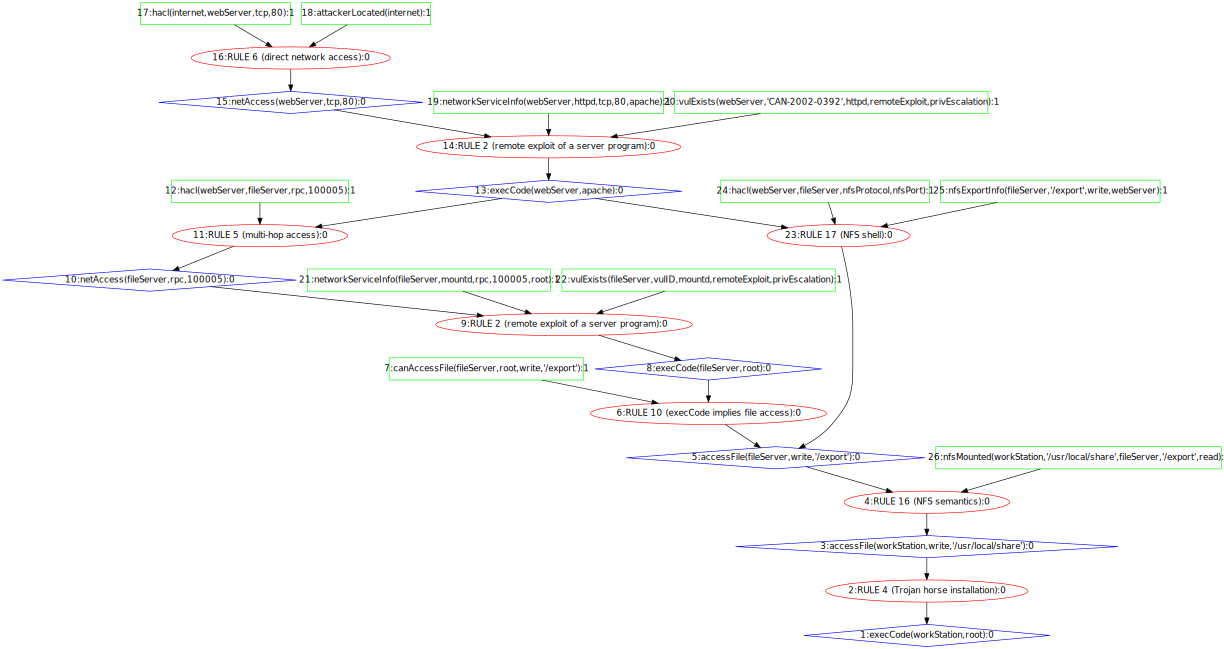

In [2]:
ag = AttackGraph()
ag.load_dot_file('/opt/projects/diss/py-mulval/data/mulval_ag/small_enterprise/AttackGraph.dot')
ag.name = 'small_enterprise'

plot_ag(ag)

## Working with Transition Scores
A large number of the metrics studied depend on transition weights for determining security properties. 

A MulVal vulnerability doesn't have to be a CVSS score, it's just a string thats asserted in the `vulExists/5` datalog fact:

```[label="20:vulExists(webServer,'CAN-2002-0392',httpd,remoteExploit,privEscalation):1",shape=box];```

We also have non-exploit transitions in an attack graph. For example, when an attacker gains another account's credentials, accessing systems with those credentials isn't an exploit. Often these amount to 0-cost transition weights which break models that rely on invertible matrix representions of the transitions. 

We demonstrate our method of graph reduction in another notebook. Here we just show how to specify which types of nodes are coalesced in this process, along with some ways to override vulnerability scores for testing. 

### yaml overrides

The `coalesce_rules` dictionary defines which nodes to reduce by rule name or regex. These typically correspond to lateral movements in a multi stage attack, where an attacker can pivot to another system without the need to run an exploit. Any matched transition nodes in this dict will have each parent (inbound edge) joined to each child (outbound edge). 

The weight assigned to each transition can be adjusted in several ways. By default, if a vulnerability is found in the NVD database, the base score is assigned. This can be adjusted by other (temporal/impact/...) CVSS vectors as well. If a vulnerability isn't found in the NVD, a default score can be assigned for all non-matching vulns. If a vulnerability ID is defined in the `exploitDict`, that score will override the NVD lookup only for that vuln_id. If a vulnerability class or type is defined in `exploit_rules`, any vulnerability of that type will receive the associated score. For benchmarking and calibrating metrics, we can fix all scores to a specific value by passing the `--secmet_fix_cvss_score=4.2` flag in Boromir, or by setting the `fix_cvss_score` property on the AttackGraph instance when using the SECMET library directly.



In [34]:
!cat /opt/projects/diss/py-mulval/data/scoreDict.yml

#scoreDict:
#  'direct network access': 10
#  'NFS shell': 9.5
#  'execCode implies file access': 7.8
#  'NFS semantics': 9.6
#  'Trojan horse installation': 5
#  'local exploit': 5
#  'any machine he has an account on will also be compromised': 9
#  'through a log-in service': 9
#  'CVE-2014-9796': 6.8
#  'CVE-2015-7501': 2
#  'CVE-2016-xxxx': 9.5

# @TODO assign rule id
coalesce_rules: # list of AND rules to coalesce
#- 'NFS shell'
#- 'execCode implies file access'
#- 'NFS semantics'
#- 'When a principal is compromised any machine he has an account on will also be compromised'
  - 'na_001'
  - 'na_002'
  - 'multi-hop access by gateway'
  - 'multi-hop access'
  - 'direct on-host access'
  - 'direct network access'
  - 'log in for ftpd'
  - 'Access a host through a log-in service'

# @TODO assign rule id
exploit_rules: # dict of AND rules to add to tmatrix
#  'arpSpoofVuln': 1
#  'password sniffing through spoof': 2
  'remote exploit of a server program': 3
  'Trojan horse installation

The following example demonstrates how to load the score dictionary described above for defining reduction rules and overriding transition values. 

The `ag.PLOT_INTERMEDIATE_GRAPHS = False` flag can be set to true to write graph diagrams to disk (useful for debugging)

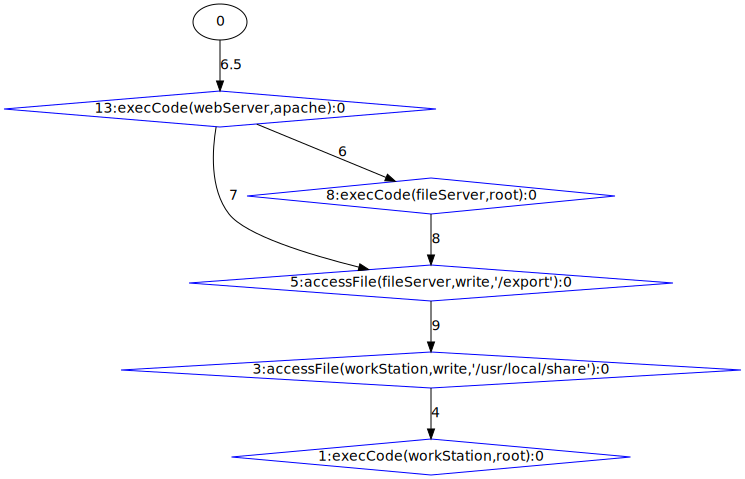

In [3]:
ag.load_score_dict('/opt/projects/diss/py-mulval/data/scoreDict.yml')
ag.PLOT_INTERMEDIATE_GRAPHS = False
reduced_ag = ag.getReducedGraph()
plot_ag(reduced_ag)

## Generate the Transition Matrix

Markov Models and other metrics that require a transition matrix can use the `getTransMatrix()` method of AttackGraph. The tgraph is the reduced graph with weights normalized and self edges representing the probability of failing to advance into one of the outbound edges. 

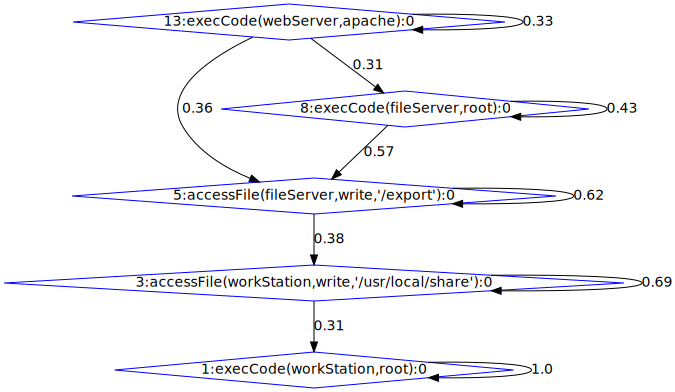

In [4]:
tgraph, tmatrix, nodelist = ag.getTransMatrix()
plot_ag(tgraph)


The transition matrix and label vector are returned separately from the call to `getTransMatrix()`

In [5]:
print(np.vstack((nodelist, np.round_(tmatrix.todense(), decimals=2))))

[['13' '8' '5' '3' '1']
 ['0.33' '0.31' '0.36' '0.0' '0.0']
 ['0.0' '0.43' '0.57' '0.0' '0.0']
 ['0.0' '0.0' '0.62' '0.38' '0.0']
 ['0.0' '0.0' '0.0' '0.69' '0.31']
 ['0.0' '0.0' '0.0' '0.0' '1.0']]


## Mapping Transition Scores To Other Systems

In several papers CVSS scores (0-10) are not the basis of transition weights. In these instances we could define scores explicitly by passing a `scoreDict`, but some cases it's more appropriate to map CVSS scores onto another systemd. 

For example, in Dacier_96 and Ortalo_99, the authors use discrete values based on exponential distributions to represent the mean time or effort needed for an attack to succeed. In these cases we can provide a map to our AttackGraph and score these transitions appropriately.

In [17]:

print(attack_graph.time_dict)
print(attack_graph.effort_dict)

{(0, 1.6): 0.0002, (1.6, 3.3): 0.02, (3.3, 5): 0.2, (5, 6.6): 1, (6.6, 8.3): 5, (8.3, 10): 50}
{(0, 2.5): 1, (2.5, 5): 0.1, (5, 7.5): 0.01, (7.5, 10): 0.001}


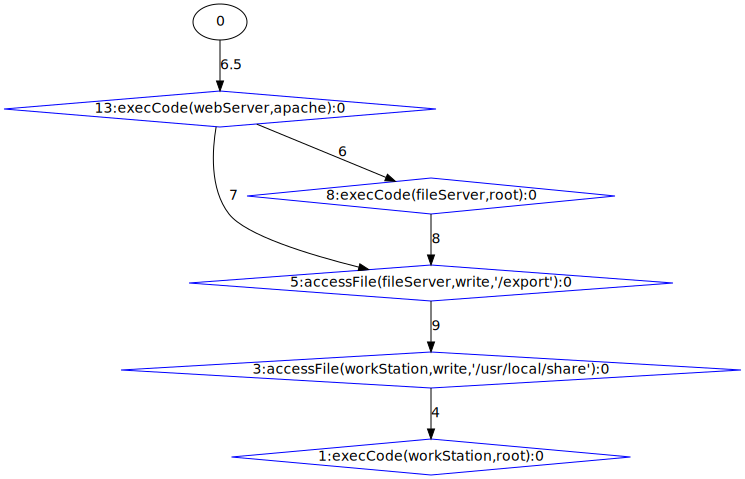

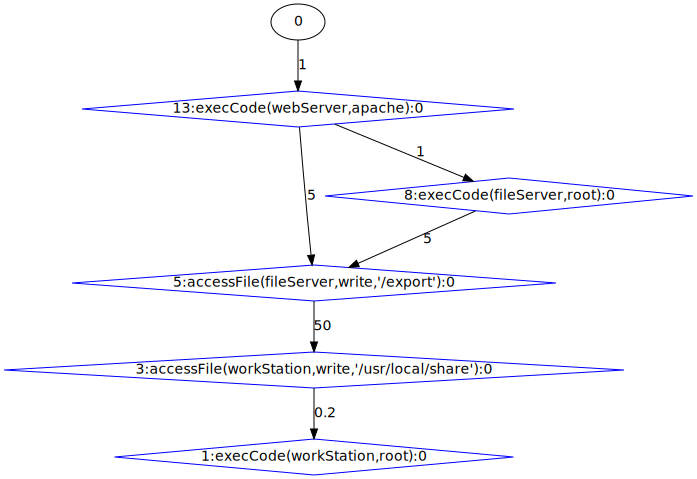

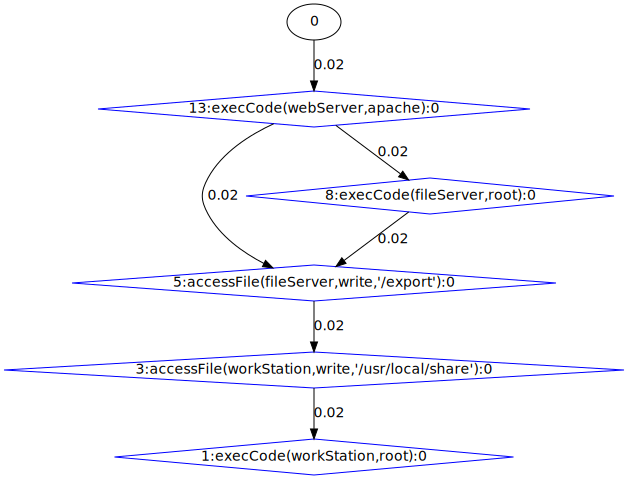

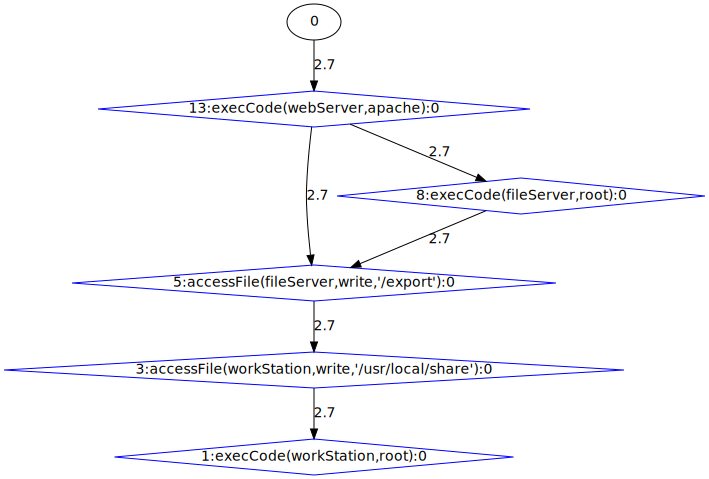

In [21]:

ag = AttackGraph()


ag.load_dot_file('/opt/projects/diss/py-mulval/data/mulval_ag/small_enterprise/AttackGraph.dot')
ag.name = 'small_enterprise'

# ag.load_score_dict('/opt/projects/diss/py-mulval/src/py_mulval/data/secmet/scoreDict_mttf.yml')
ag.load_score_dict('/opt/projects/diss/py-mulval/src/py_mulval/data/secmet/scoreDict.yml')
ag.PLOT_INTERMEDIATE_GRAPHS = False
# ag.map_scores = 'cvss2effort'
# ag.map_scores = 'cvss2time'

# 1. Show weights from the loaded score dict (cvss based)
reduced_ag = ag.getReducedGraph()
display(plot_ag(reduced_ag))

# 2. show scores mapped to times (from Dacier_99)
ag.map_scores = 'cvss2time'
reduced_ag = ag.getReducedGraph()
display(plot_ag(reduced_ag))

# 3. show scored fixed at value (still mapped to time)
ag.fix_cvss_score = 2.7
reduced_ag = ag.getReducedGraph()
display(plot_ag(reduced_ag))


# 4. unset map_scores var to unmap and show fixed scores
ag.map_scores = None
reduced_ag = ag.getReducedGraph()
display(plot_ag(reduced_ag))

## Mean Time to Failure (mttf_dacier_1994)
Dacier\cite{Dacier_1994, Dacier_1996}:

Dacier's privilege graph model assumes the probability $P$ to succeed in a given attack before time $t$ is described by an exponential distribution: 

$P(t) = 1-exp(-\lambda t) $ 

$P(t) = 1-e^{-\lambda t} $

Transition rate $\lambda$ estimates the effort and time, with mean time for an attack to succeed given by 

$\frac{1}{\lambda}$.

The mean time $T_j$ spent in state $j$ is :

$T_j = 1 / \sum\limits_{i\in out(j)}\lambda_{ji}$

... and the $MTTF_k$ is mean time to failure when state $k$ is the initial state and $P_{k1}$ the conditional probability from state $k$ to state $1$:

$MTTF_k = T_k + \sum\limits_{1\in out(k)}P_{k1} ; P_{k1}=\lambda_{k1} \times T_k$


The shortest path is:

$\textbf{SP} = min(MTTF_k)$  for all possible paths


In [97]:
# src: http://bois.caltech.edu/dist_stories/
params = [dict(name='λ', start=.0002, end=40, value=5, step=0.1)]
app = distribution_plot_app(x_min=0,
                            x_max=50,
                            scipy_dist=st.poisson,
                            params=params,
                            x_axis_label='n (# arravals)',
                            title='Poisson')
bokeh.io.show(app, notebook_url=notebook_url)

#### Discussion

Dacier chooses an exponential distribution to model the probability an attack will succeed before a given time $t$. 

Exponential distributions model the arrival rate of a Poisson process. In a Poisson process, the assumption is that rare events occur with a rate $\lambda$ per unit time (1 week in our case, see below), and that rate is independent of time ("memoryless"). When an event occurs it is called an "arrival". The exponential distribution describes the waiting time for an arrival from a Poisson process. 


The graph above shows the PMF and CDF of the Poisson process for different arrival rates.

The *PMF* (probability mass function) shows the probability (y-axis) that a discrete random variable is exactly equal to n (x-axis). 

The *CDF* (cumulative distribution function) shows the probability (y-axis) the random variable will take a value less than or equal to n (x-axis)

The *PDF* (probability density function) is somewhat analogous to the PMF for continuous random variables, where the probability that the RV falls within some narrow interval on the x-axis $(x, \Delta x)$ is the area under the PDF curve between $f(x)$ and $f(\Delta x)$. *ie, y-axis is not probability here*

In [120]:
params = [dict(name='λ', start=0.0002, end=50, value=1, step=0.001)]
app = distribution_plot_app(0,
                            10,
                            st.expon,
                            params=params,
                            transform=lambda x: (0, 1/x), 
                            x_axis_label='t (time in weeks)',
                            title='Exponential')
bokeh.io.show(app, notebook_url=notebook_url)


The probability density of the exponential distribution with rate $\lambda$  and time $t$ is given by: 

$p(t) ~ = \lambda e^{-\lambda t}, ~~~ t \ge 0$

Remember in this context that $p(t)$ describes the probability of an attack being successful between times $t$ and some later time $t + \Delta$ as the area under the PDF curve, not the value $p(t)$. The CDF for time $t$ is the probability of a successful attack occuring before time $t$:


$
\begin{align*}
P(t) ~ &= ~ P(T \le t) \\
&= ~ \int_0^t \lambda e^{-\lambda s}ds \\
&= ~ -e^{-\lambda s} \big{|}_0^t \\
&= ~ 1 - e^{-\lambda t}
\end{align*}
$

Dacier defines the following attack success rates:
```
.0002 is quasi-instantanious
.02 is 1 hour
.2 is 1 day
1 is 1 week
5 is one month
50 is one year
```
... so the unit time in this case is 1 week. 

Arrival rate $\lambda$ is the expected number of arrivals per unit time (week), so inverting this rate gives the expected time between arrivals. In context, this is the mean time to successfully exploit a specific vulnerability: 

$E(t) = \frac{1}{\lambda} = \lambda^{-1}$


NameError: name 'f' is not defined

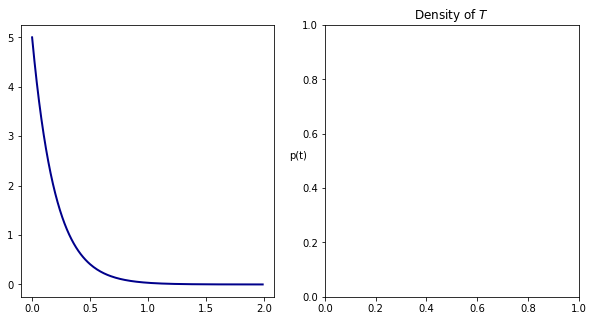

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))


lamb = 5
t = np.arange(0, 2, 0.01)
y_pdf = st.expon.pdf(t, scale=1/5)

ax[0].plot(t, y, color='darkblue', lw=2)

w = np.arange(0, 0.801, 0.01)
ax[0].fill_between(w, f(w), color='gold')




plt.ylabel('p(t)', rotation=False)
plt.title('Density of $T$');
plt.xlabel('time (in weeks)')

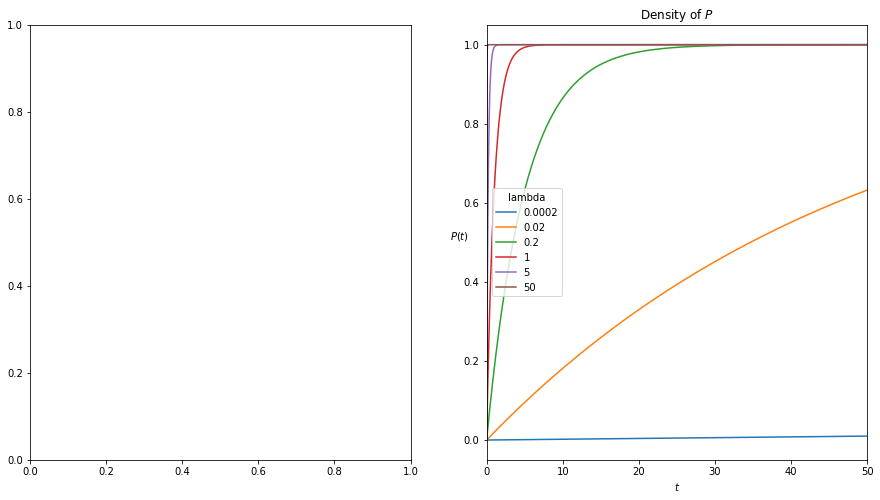

In [77]:


fig, ax = plt.subplots(1, 2, figsize=(15, 8))


# mean time to fire transitions:
# .0002 is quasi-instantanious
# .02 is 1 hour
# .2 1 day
# 1 is 1 week
# 5 is one month
# 50 is one year
lams = [.0002, .02, .2, 1, 5, 50]

lam = 5
t = np.arange(0, 50, 0.01)
# y = expon.pdf(t, scale=1/5)
for lam in lams:
    y =  expon.cdf(t, scale=1/lam)
    ax[1].plot(t, y, label=lam)
plt.xlabel('$t$')
plt.ylabel('$P(t)$', rotation=False)
# ax[1].set_ylim([0,5])
ax[1].set_xlim([0,50])
ax[1].legend(title='lambda')
plt.title('Density of $P$');

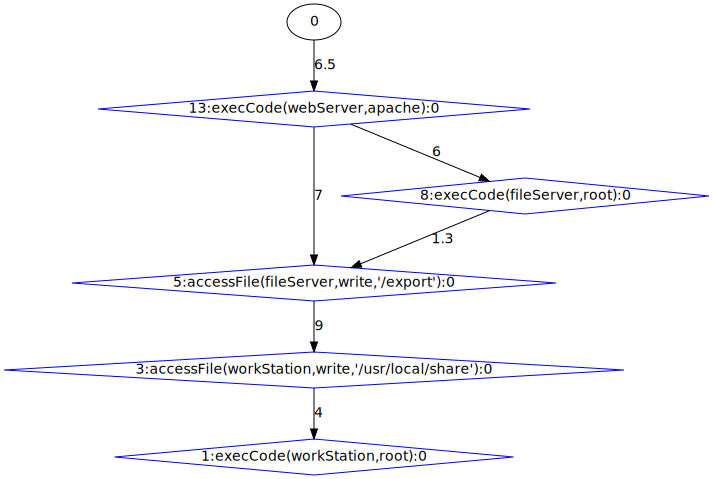

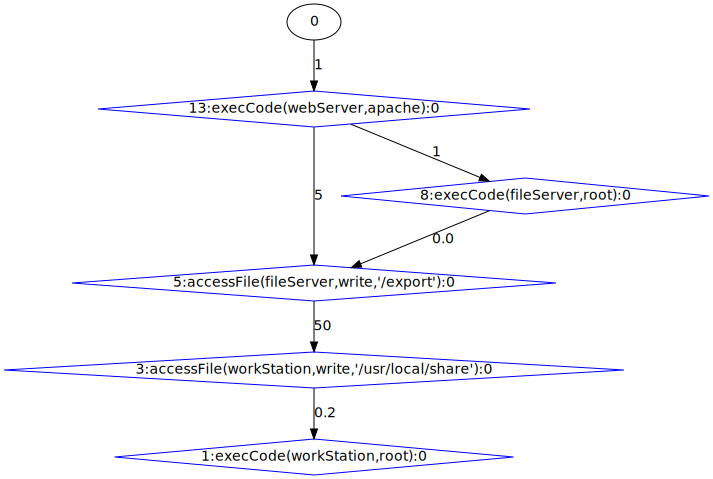

In [28]:

ag = AttackGraph()


ag.load_dot_file('/opt/projects/diss/py-mulval/data/mulval_ag/small_enterprise/AttackGraph.dot')
ag.name = 'small_enterprise'

# ag.load_score_dict('/opt/projects/diss/py-mulval/src/py_mulval/data/secmet/scoreDict_mttf.yml')
ag.load_score_dict('/opt/projects/diss/py-mulval/src/py_mulval/data/secmet/scoreDict.yml')
ag.PLOT_INTERMEDIATE_GRAPHS = False


reduced_ag = ag.getReducedGraph()
display(plot_ag(reduced_ag))

# ag.map_scores = 'cvss2effort'
ag.map_scores = 'cvss2time'

reduced_ag = ag.getReducedGraph()
display(plot_ag(reduced_ag))



To find the shortest path in Dacier's model, sum the times for each path where 


In [29]:

nodelist = reduced_ag.getNodeList(includeSource=True)
tmatrix  = nx.adjacency_matrix(reduced_ag, nodelist)
print(tmatrix.todense())
print(np.vstack((nodelist, tmatrix.todense())))

[[0.e+00 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+00 5.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 2.e-04 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 5.e+01 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 2.e-01]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
[['0' '13' '8' '5' '3' '1']
 ['0.0' '1.0' '0.0' '0.0' '0.0' '0.0']
 ['0.0' '0.0' '1.0' '5.0' '0.0' '0.0']
 ['0.0' '0.0' '0.0' '0.0002' '0.0' '0.0']
 ['0.0' '0.0' '0.0' '0.0' '50.0' '0.0']
 ['0.0' '0.0' '0.0' '0.0' '0.0' '0.2']
 ['0.0' '0.0' '0.0' '0.0' '0.0' '0.0']]


## Mean Effort to Failure (mttf_ortalo_1999)
Ortalo\cite{Ortalo_19999}:

Ortalo's privilege graph model assumes the probability to succeed in a given attack before expending effort $e$ is described by an exponential distribution given by: 

$P(t) = 1-exp(-\lambda e) $  

Transition rate $\lambda$ estimates the effort, with mean effort for an attack to succeed given by 

$\frac{1}{\lambda}$.

The mean effort $E_j$ spent in state $j$ is:

$E_j = 1 / \sum\limits_{i\in out(j)}\lambda_{ji}$

... and the $METF_k$ is mean time to failure when state $k$ is the initial state and $P_{k1}$ the conditional probability from state $k$ to state $1$:

$METF_k = T_k + \sum\limits_{1\in out(k)}P_{k1} ; P_{k1}=\lambda_{k1} \times E_k$


The shortest path is:

$\textbf{SP} = min(METF_k)$  for all possible paths


<class 'numpy.ndarray'>


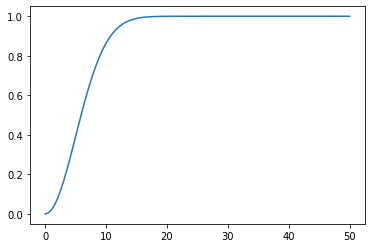

In [7]:
from scipy.stats import expon

fig, ax = plt.subplots(1, 1)

# Attack success rate levels:
# 1 is level 1 (easiest, lowest effort attack)
# .1 is level 2
# .01 is level 3
# .001 is level 4 (toughest, highest effort attack)

x = np.linspace(.0002, 50, 100)
np.
print(type(x))
lamb = np.linspace(0.0001,.9999, 100)
# print(x)
ax.plot(x, 1 - expon.pdf(x * lamb), label='P(t)')

In [31]:


effort_dict = {(0, 2.5): 1, 
               (2.5, 5): 0.1,
               ( 5, 7.5): 0.01,
                (7.5, 10): 0.001
              }
# not using np.interp to match paper assumptions
def translate_cvss(parted_dict, score):
    for key in parted_dict:
        if key[0] <= score <= key[1]:
            return parted_dict[key]
        
vfunc = np.vectorize(translate_cvss, otypes=[float])
vfunc(effort_dict, [0,1,2,3,4,5, 6, 7, 8, 9, 10])

array([1.   , 1.   , 1.   , 0.1  , 0.1  , 0.1  , 0.01 , 0.01 , 0.001,
       0.001, 0.001])

In [32]:
np.linspace(0,10,7)

array([ 0.        ,  1.66666667,  3.33333333,  5.        ,  6.66666667,
        8.33333333, 10.        ])